In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq

from best_subset import *
from solvel0 import solvel0
from UBIC import fit_blr, UBIC, decreasing_values_indices

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold

from findiff import FinDiff

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def AIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # AIC
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    return N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)

# Sensitivity to epsilon was never discussed!
def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord=2)**2 
    # llf = ssr2llf(rss, N)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # N*np.log(2*np.pi*rss/N) + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)
fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return Theta_grouped, Ut_grouped

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    # normalize 
    for i in range(m):
        As[i] = As[i].dot(np.diag(candidate_norms**-1))
        bs[i] = bs[i]/norm_bs[i]
        
    return As, bs

def remove_f(uu, percent):
    if percent <= 0: return uu
    PSD = (uu*np.conj(uu))/np.prod(uu.shape)
    PSD = PSD.real
    mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    return uu*mask

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

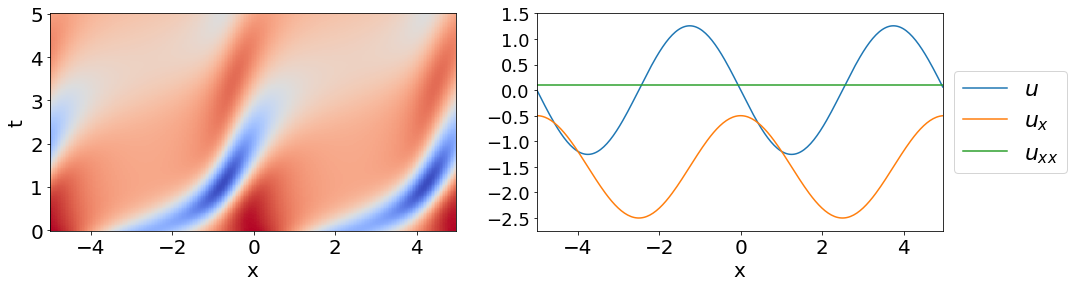

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
show()
# fig.tight_layout()

In [5]:
noise_lv = 2
noise_lv = abs(noise_lv)
u_clean = u.copy()
u = u + 0.01*noise_lv*std(u)*np.random.randn(*u.shape)

In [6]:
is_denoising = True
if is_denoising:
    window_size = 15
    poly_order = 2
    # equivalent to np.hstack([savgol_filter(u[:, i], window_size, poly_order).reshape(-1, 1) for i in range(u.shape[-1])])
    u = savgol_filter(u, window_size, poly_order, axis=0)

In [7]:
# Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')
# Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
# Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]

# physics is such fundamental that it can be discovered from in low-freq data (validation set)
fft_percent = 90
acc = 8
d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(u)
d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(u)
d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(u)
d_dt = FinDiff(1, dx, 1, acc=acc); u_t = d_dt(u)
    
phi1 = [u**i for i in range(0, 4)]; phi1_names = ["", "u", "u^{2}", "u^{3}"]
phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
phi = phi1.copy(); phi_names = phi1_names.copy()
phi.extend([p1*p2 for p1 in phi1 for p2 in phi2])
phi = np.array(phi)
phi_names.extend([p1+p2 for p1 in phi1_names for p2 in phi2_names])
fft_phi = [remove_f(np.fft.fft(_, axis=-1), fft_percent) for _ in phi]
fft_u_t = remove_f(np.fft.fft(u_t, axis=-1), fft_percent)

Theta_grouped = np.moveaxis(phi, 0, -1)
Ut_grouped = np.expand_dims(u_t, -1)
rhs_des = phi_names
fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

del phi1, phi2, phi1_names, phi2_names

1 u
4 u_{x}
5 u_{xx}
6 u_{xxx}
8 uu_{xx}
11 u^{2}u_{xx}
14 u^{3}u_{xx}


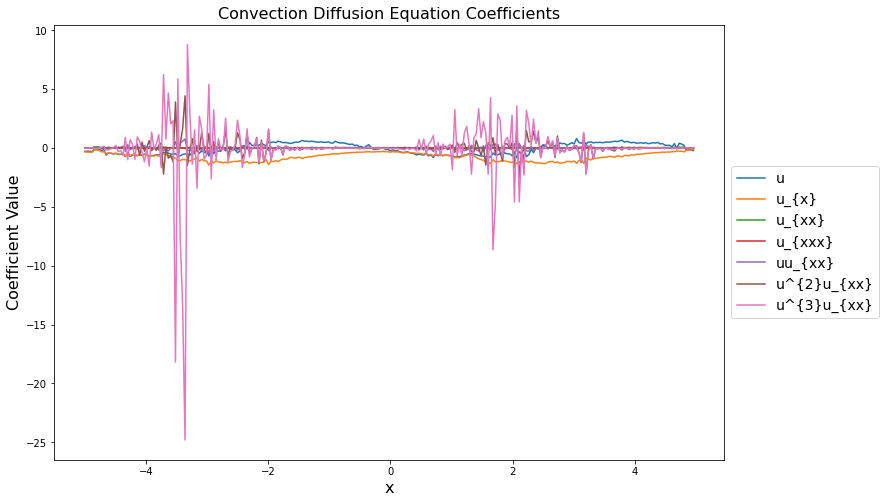

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
# percent = 90
# est_xi = []
# for i in range(fu.shape[0]):
#     # phi_g = np.vstack((u[i:i+1, :], u_x[i:i+1], u_xx[i:i+1])).T
#     # u_t_g = u_t[i:i+1, :].reshape(-1, 1)
#     f1, f2, f3 = fu, fu_x, fu_xx
#     f1, f2, f3 = remove_f(f1, percent), remove_f(f2, percent), remove_f(f3, percent)
#     phi_g = np.vstack((f1[i:i+1, :], f2[i:i+1], f3[i:i+1])).T
#     u_t_g = fu_t[i:i+1, :].reshape(-1, 1)
#     est_xi.append(np.linalg.lstsq(phi_g, u_t_g, rcond=None)[0])
# est_xi = np.hstack(est_xi)

# est_xi  = linear_fit_grouped_data((Theta_grouped, Ut_grouped), (1, 4, 5))
# plt.plot(est_xi[0])
# plt.plot(est_xi[1])
# plt.plot(est_xi[2]); plt.show()

In [10]:
candidates = set()
# max_complexity=X_weak.shape[-1]
max_complexity = 10
for i in trange(len(Theta_grouped)):    
    candidates = candidates.union(set(solvel0(Theta_grouped[i], Ut_grouped[i], 
                                              max_complexity=max_complexity, 
                                              miosr=True, refine=True, verbose=False)))
candidates

  0%|                                                                                                                       | 0/256 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:31<00:00,  2.81it/s]


{(1, 3, 4, 6, 10, 12, 13, 15),
 (1, 3, 4, 5, 9, 11, 13, 14, 15),
 (1, 3, 4, 7, 8, 11, 12, 13, 14),
 (1, 4, 5, 6, 8, 9, 10, 14, 15),
 (0, 1, 2, 3, 5, 6, 10, 12, 14, 15),
 (1, 2, 4, 6, 8, 14),
 (0, 1, 2, 4, 6, 8, 9, 10, 14, 15),
 (0, 1, 3, 4, 5, 8, 9, 12, 15),
 (1, 3, 4, 5, 6, 14, 15),
 (1, 3, 4, 5, 6, 10, 11, 13, 14, 15),
 (1, 2, 3, 4, 5, 8, 10, 11, 13, 14),
 (0, 1, 2, 4, 5),
 (0, 1, 2, 3, 4, 5, 6, 7, 11, 14),
 (1, 4, 5, 7, 13),
 (1, 3, 4, 5, 10, 11, 12),
 (0, 2, 4, 6),
 (1, 2, 3, 4, 5, 11),
 (2, 4, 5),
 (0, 1, 2, 3, 4, 5, 6, 10, 11, 12),
 (1, 3, 4, 12, 14),
 (1, 3, 4, 6, 7, 9, 15),
 (4, 5, 6, 11, 14, 15),
 (0, 2, 3, 4, 6, 10, 12, 14, 15),
 (0, 1, 2, 3, 4, 6, 7, 13),
 (0, 1, 2, 4, 8, 15),
 (0, 1, 3, 4, 5, 6, 8, 11),
 (3, 15),
 (1, 4, 8, 9, 10, 11, 12, 14, 15),
 (1, 4, 6, 12, 13, 14, 15),
 (1, 2, 4, 5, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 4, 5, 6, 7, 9, 11, 12, 14, 15),
 (0, 1, 2, 4, 5, 6, 7, 10, 11, 14),
 (0, 1, 4, 5, 9, 12),
 (1, 2, 3, 4, 6, 7, 12, 15),
 (3, 4, 5, 10, 11, 13, 15),
 (0, 1, 

In [11]:
lam = 0
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print(lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss
candidates = set([e[0] for e in list(track.values())])
candidates

59.6726680587608


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1384/1384 [02:56<00:00,  7.84it/s]


{(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 15),
 (0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 13, 15),
 (0, 1, 2, 3, 4, 5, 7),
 (0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 15),
 (0, 1, 2, 4, 5, 6, 7, 8, 13),
 (0, 1, 3, 4, 5, 6, 7, 8),
 (0, 1, 4, 5, 7, 8),
 (1, 4, 5),
 (1, 4, 5, 6, 7),
 (1, 4, 5, 7),
 (4,),
 (4, 5)}

13


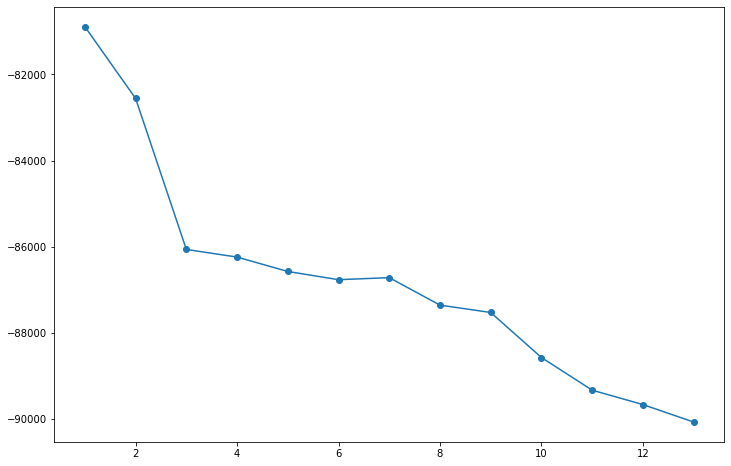

In [12]:
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
    aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]
print(complexities[np.argmin(aics)])
plt.plot(complexities, aics, '-o'); plt.show()

13


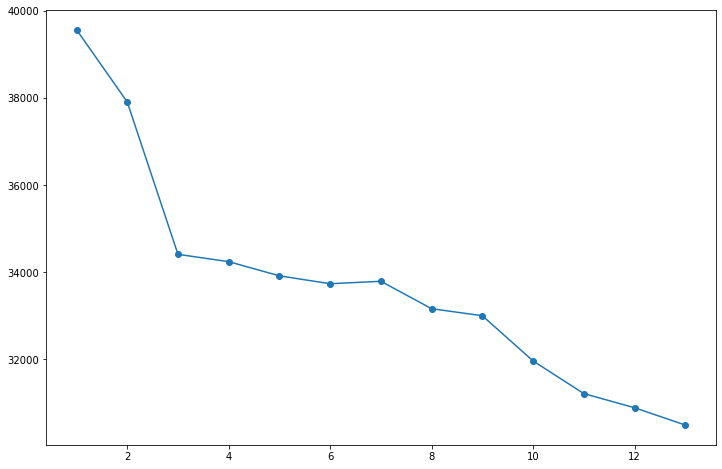

In [13]:
print(complexities[np.argmin(bics)])
plt.plot(complexities, bics, '-o'); plt.show()

In [14]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction)**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    ### For Ridge ###
    # uncert = np.hstack(est_xi)
    # uncert = uncert.std(axis=1).sum()/np.abs(uncert.mean(axis=1)).sum()
    # uncert = np.mean(uncert.std(axis=1)/np.abs(uncert.mean(axis=1)))
    # uncert = np.mean(uncert.std(axis=1))
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 1287.44it/s]


epsilon 246.74675421449035
3
(1, 4, 5)


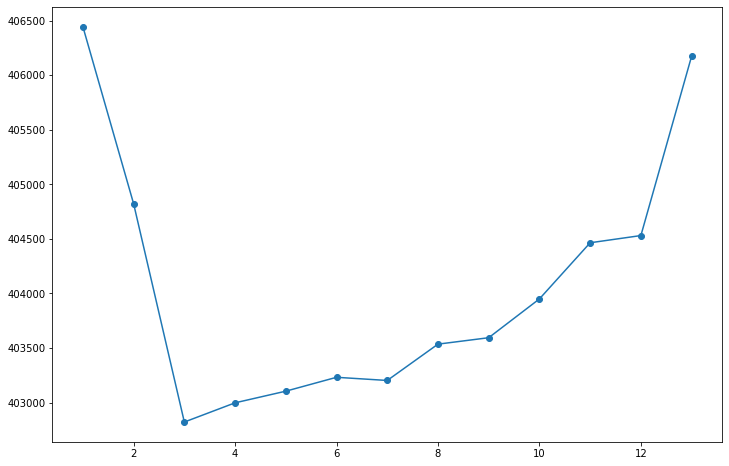

In [15]:
nobs = Theta_grouped[0].shape[0]*len(Ut_grouped)
min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
epsilon = 1
epsilon = epsilon*max(1e-5, np.max([2*np.pi*best_subsets[com][0]/nobs for com in best_subsets]))
print("epsilon", epsilon)
complexities = sorted(best_subsets.keys())
bics = []
uncertainties = []
for com in complexities:
    rss, uncert, indices = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
    bics.append(rss2bic(rss, com+uncert, nobs, epsilon))
uncertainties = np.array(uncertainties)
best_indices = best_subsets[complexities[np.argmin(bics)]][-1]
print(complexities[np.argmin(bics)])
print(best_indices)
plt.plot(complexities, bics, '-o'); plt.show()

In [16]:
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    rss, _, indices = best_subsets[com]
    assert com == len(indices)
    # lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bound = 2*ssr2llf(rss, nobs)/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
    
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = np.argmin(last_ubic)

thres = 1e-4
percent = 75
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]

    imp = np.nan
    if np.abs(diff_com) > 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))

    if verbose:
        print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        print("break")
        break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
last_lam, last_ubic, last_bc

(1, 4, 5) selected


(8.0,
 array([406433.23035836, 404806.82374803, 402802.83340399, 402964.36951272,
        403061.1084607 , 403179.04366499, 403122.99865728, 403415.12847212,
        403452.38083231, 403781.43115008, 404286.90662538, 404334.20444335,
        405966.60839392]),
 2)

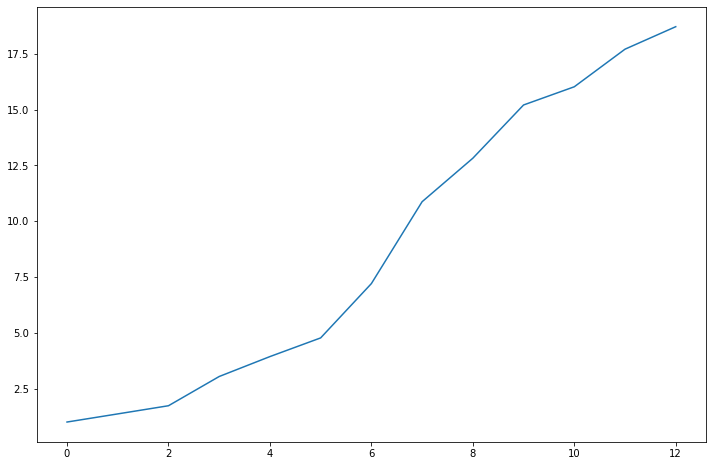

In [17]:
plt.plot(uncertainties); plt.show()

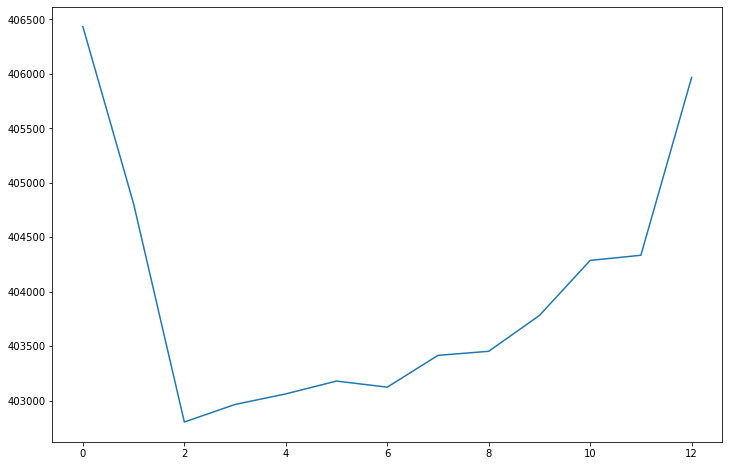

In [18]:
plt.plot(last_ubic); plt.show()